In [1]:
###Import python required modules
!pip install yfinance
!pip install sklearn_recommender
import yfinance as yf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#pip install sklearn-recommender
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

import sklearn_recommender as skr
from functools import reduce
import seaborn as sns
import string
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler

     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=a19851861b0ee2111a5948cbb3e86bf5e7c2941feb2fbb674b2e4819a1661856
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for sklearn-recommender: filename=sklearn_recommender-0.1.5-py3-none-any.whl size=17466 sha256=3720e7f05e8deb7a218bbcee8c3abc830985892508effa20c70188a6a5d1d7b0
  Stored in directory: /root/.cache/pip/wheels/d6/bb/91/6f0ed3d18b73ab69d4a653e84a3e94f8369a53839dabc744ed
Successfully built sklearn-recommender
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]    

In [2]:
##Method to create the stock profile with the symbol, sector, industry and description
def create_stock_profile(company1name,company2name,company3name,company4name,company5name,company6name,company7name):
  company1 = yf.Ticker(company1name)
  company2 = yf.Ticker(company2name)
  company3 = yf.Ticker(company3name)
  company4 = yf.Ticker(company4name)
  company5 = yf.Ticker(company5name)
  company6 = yf.Ticker(company6name)
  company7 = yf.Ticker(company7name)
  stocks_data  = {'symbol':[company1.info['symbol'],company2.info['symbol'],company3.info['symbol'],company4.info['symbol'],company5.info['symbol'],company6.info['symbol'],company7.info['symbol']],'Company':[company1.info['longName'],company2.info['longName'],company3.info['longName'],company4.info['longName'],company5.info['longName'],company6.info['longName'],company7.info['longName']],'sector':[company1.info['sector'],company2.info['sector'],company3.info['sector'],company4.info['sector'],company5.info['sector'],company6.info['sector'],company7.info['sector']],'industry':[company1.info['industry'],company2.info['industry'],company3.info['industry'],company4.info['industry'],company5.info['industry'],company6.info['industry'],company7.info['industry']],'description':[company1.info['longBusinessSummary'],company2.info['longBusinessSummary'],company3.info['longBusinessSummary'],company4.info['longBusinessSummary'],company5.info['longBusinessSummary'],company6.info['longBusinessSummary'],company7.info['longBusinessSummary']]}#'exchange'}
  stocks_data = pd.DataFrame(stocks_data)
  # print(stocks_data)
  return stocks_data

In [3]:
###Creates the similarity transformer data based on sector and industry and returns the stocks similar to a certain stock company
def similarity_stocks_sector_industry(stocks_data,symbol,sim_trans_threshold):
    #Performing one hot encoding for the data
    stocks_data_sector_dummy = pd.get_dummies(stocks_data['sector'], dummy_na=False, prefix='sector')###Set dummy_na = true if a column is required for NAN values
    #print(stocks_data_sector_dummy)
    
    stocks_data_industry_dummy = pd.get_dummies(stocks_data['industry'], dummy_na=False, prefix='industry')
    #print(stocks_data_industry_dummy)
    #df_exchange_dummy = pd.get_dummies(df_profile['exchange'], dummy_na=True, prefix='exchange')
    
    stocks_data_categories = pd.concat([stocks_data['symbol'], stocks_data_sector_dummy, stocks_data_industry_dummy], axis=1)
    #print(stocks_data_categories)##This dataframe will consist of the stock symbol and the one hot encoded of sector and industry

    # generating similarity matrix between the two company data
    sim_transformer = skr.transformer.SimilarityTransformer(cols=(1, None), index_col='symbol', normalize=True)
    stocks_data_similarity = sim_transformer.transform(stocks_data_categories)##The similarity matrix

    ##Printing the similarity matrix
    # print(stocks_data_similarity)##Companies with matching sector or industry will have higher similarity
    '''This similarity is just a measure of the stocks that are related and nothing else'''
    
    ###Get the similarity matrix row for the company we are currently viewing
    df_row = stocks_data_similarity.loc[symbol].sort_values(ascending=False)##Getting the similarity value of the stock
    #print(symbol)
    df_row = df_row[df_row > sim_trans_threshold]##Getting the column with the simialrity value higher
    #print(df_row)
    similar_stocks = []
    for col in df_row.index:
        if isinstance(col, float): continue
        if col not in similar_stocks:
            if col!=symbol:
                similar_stocks.append(col)
    return symbol, similar_stocks

In [4]:
##Method to compare the returns and volatilites of the companies/stocks
def returns_and_volatility(company1symbol,company2symbol,company3symbol,company4symbol,company5symbol,company6symbol, wholedata):
  ###Fetch the historical records of all the 6 companies/stocks
  company1 = yf.Ticker(company1symbol)
  company2 = yf.Ticker(company2symbol)
  company3 = yf.Ticker(company3symbol)
  company4 = yf.Ticker(company4symbol)
  company5 = yf.Ticker(company5symbol)
  company6 = yf.Ticker(company6symbol)

  #Fetching recent data of companies of 1 year prior from today
  company1dataset = company1.history(period="1y")
  company1dataset.reset_index(inplace=True)
  company2dataset = company2.history(period="1y")
  company2dataset.reset_index(inplace=True)
  company3dataset = company3.history(period="1y")
  company3dataset.reset_index(inplace=True)
  company4dataset = company4.history(period="1y")
  company4dataset.reset_index(inplace=True)
  company5dataset = company5.history(period="1y")
  company5dataset.reset_index(inplace=True)
  company6dataset = company6.history(period="1y")
  company6dataset.reset_index(inplace=True)
  # print(company1dataset)
  
  all_comp_datasets = [company1dataset[['Date','Open']],company2dataset[['Date','Open']],company3dataset[['Date','Open']],company4dataset[['Date','Open']],company5dataset[['Date','Open']],company6dataset[['Date','Open']]]##get only the open and date for both dataset
  
  combined_data = reduce(lambda left,right: pd.merge(left,right,on='Date'), all_comp_datasets).iloc[:, 1:]##Next combines the dataset based on the date,
  
  #as all the stocks data are from same ASX and so same date will be there for all
  # print(combined_data.head())
  combined_data.columns = [company1symbol,company2symbol,company3symbol,company4symbol,company5symbol,company6symbol]
  if (wholedata):
    ###Performing the analysis on the total data
    total_days = len(combined_data)
    stock_returns = combined_data.pct_change()##We compute the percentage change between each data which will record how fluctuating the data can get
    mean_stock_daily_returns_total = stock_returns.mean()
    stock_volatilities_total = stock_returns.std()
      
    analysis_result = pd.DataFrame({'returns': mean_stock_daily_returns_total * total_days,'volatility': stock_volatilities_total * total_days})
    # print(analysis_result)
      
    g = sns.jointplot(x="volatility",y="returns", data=analysis_result, kind="reg",height=7)

    plt.annotate(company1symbol, (analysis_result.iloc[0, 1], analysis_result.iloc[0, 0]))
    plt.annotate(company2symbol, (analysis_result.iloc[1, 1], analysis_result.iloc[1, 0]))
    plt.annotate(company3symbol, (analysis_result.iloc[2, 1], analysis_result.iloc[2, 0]))
    plt.annotate(company4symbol, (analysis_result.iloc[3, 1], analysis_result.iloc[3, 0]))
    plt.annotate(company5symbol, (analysis_result.iloc[4, 1], analysis_result.iloc[4, 0]))
    plt.annotate(company6symbol, (analysis_result.iloc[5, 1], analysis_result.iloc[5, 0]))
          
    plt.text(-10.0, -0.1, 'SELL', fontsize=10)
    plt.text(-10.5, 0.05, 'BUY', fontsize=10)
          
    plt.show()
  else: 
  ###Performing the analysis on the last 60 day's data
    stock_returns_last_60_days = (combined_data.pct_change()).tail(60)##Get the last 60 days data of percetage change
    mean_stock_daily_returns_60days = stock_returns_last_60_days.mean()
    stock_volatilities_60days = stock_returns_last_60_days.std()
    analysis_result_60days = pd.DataFrame({'returns': mean_stock_daily_returns_60days * 60,'volatility': stock_volatilities_60days * 60})
    
    # print(analysis_result_60days)

    g = sns.jointplot(x="volatility",y="returns", data=analysis_result_60days, kind="reg",height=10)

    plt.annotate(company1symbol, (analysis_result_60days.iloc[0, 1], analysis_result_60days.iloc[0, 0]))
    plt.annotate(company2symbol, (analysis_result_60days.iloc[1, 1], analysis_result_60days.iloc[1, 0]))
    plt.annotate(company3symbol, (analysis_result_60days.iloc[2, 1], analysis_result_60days.iloc[2, 0]))
    plt.annotate(company4symbol, (analysis_result_60days.iloc[3, 1], analysis_result_60days.iloc[3, 0]))
    plt.annotate(company5symbol, (analysis_result_60days.iloc[4, 1], analysis_result_60days.iloc[4, 0]))
    plt.annotate(company6symbol, (analysis_result_60days.iloc[5, 1], analysis_result_60days.iloc[5, 0]))
          
    plt.text(-10.0, -0.1, 'SELL', fontsize=10)
    plt.text(-10.5, 0.05, 'BUY', fontsize=10)
          
    plt.show()

In [5]:
def volume_recommendation(company1symbol):
    company = yf.Ticker(company1symbol)
    companydataset = company.history(period="1y")
    companydataset.reset_index(inplace=True)
    QANdataset = companydataset[['Close','Volume']]
    # print(QANdataset)
    QANdataset['OBV'] = 0
    ###calculate the obv values
    for i in range(0,len(QANdataset)):
        if i==0:
            QANdataset.loc[i,'OBV'] = QANdataset.loc[i,'Volume']
        else:##As per the conditions/formula the obv is calculated for the dataset
            if QANdataset.loc[i,'Close']==QANdataset.loc[i-1,'Close']:
                QANdataset.loc[i,'OBV'] = QANdataset.loc[i-1,'OBV']
            elif QANdataset.loc[i,'Close'] < QANdataset.loc[i-1,'Close']:
                QANdataset.loc[i,'OBV'] = QANdataset.loc[i-1,'OBV']-QANdataset.loc[i,'Volume']
            elif QANdataset.loc[i,'Close']>QANdataset.loc[i-1,'Close']:
                QANdataset.loc[i,'OBV'] = QANdataset.loc[i-1,'OBV']+QANdataset.loc[i,'Volume']
            else:
                QANdataset.loc[i,'OBV'] = QANdataset.loc[i-1,'OBV']
    QANdataset['Close_sma50'] = QANdataset['Close'].rolling(window=50).mean()##Calculate the simple moving average of the close
    QANdataset['OBV_sma50'] = QANdataset['OBV'].rolling(window=50).mean()##Calculate the simple moving average of the obv
    ##To generate the moving average of the movement to get the trend and the direction
    # print(QANdataset)
    
    results = []
    ###As the first 50 values are null due to moving average and so those values are not considered
    for i in range(0,60):
        results.append(0)
    for i in range(60,len(QANdataset)):
        #compute the average of the last 10 days
        avg_close = 0
        avg_obv = 0
        for j in range(0,10):##Caluclating the average sma close and the average sma obv values to compare if the current value is moving upwards or downwards
            avg_close = avg_close + QANdataset.loc[i-j,'Close_sma50']
            avg_obv = avg_obv + QANdataset.loc[i-j,'OBV_sma50']
        avg_close = avg_close/10
        avg_obv = avg_obv/10
        ##Comparing the current sma values with the average values to determine if currently the trend is moving up or down
        if ((QANdataset.loc[i,'Close_sma50']>avg_close) and (QANdataset.loc[i,'OBV_sma50']>avg_obv)):
            results.append(1)
        elif ((QANdataset.loc[i,'Close_sma50']<avg_close) and (QANdataset.loc[i,'OBV_sma50']<avg_obv)):
            results.append(0)
        elif ((QANdataset.loc[i,'Close_sma50']<avg_close) and (QANdataset.loc[i,'OBV_sma50']>avg_obv)):
            results.append(1)
        elif ((QANdataset.loc[i,'Close_sma50']>avg_close) and (QANdataset.loc[i,'OBV_sma50']<avg_obv)):
            results.append(0)
        elif (QANdataset.loc[i,'OBV_sma50']>avg_obv):
            results.append(1)
        elif (QANdataset.loc[i,'OBV_sma50']<avg_obv):
            results.append(0)
    #plt.figure()
    f,axes = plt.subplots(3,1)
    axes[0].plot(QANdataset['OBV'])
    axes[0].plot(QANdataset['OBV_sma50'])
    axes[1].plot(QANdataset['Close'])
    axes[1].plot(QANdataset['Close_sma50'])
    axes[2].plot(QANdataset['Volume'])
    plt.show()
    #Scaling the sma values to be able to plot in a same graph
    sc = MinMaxScaler()#setting the range between 0 and 1
    QANdataset_scaled = sc.fit_transform(QANdataset)#Transform the training set into scaled features
    # print(QANdataset_scaled)
    close = []
    obv = []
    for sc in QANdataset_scaled:
        close.append(sc[3])
        obv.append(sc[4])
    #plt.figure()
    ###Plot 2 subplots
    #Subplot 1 is sclaed sma close and scaled sma obv
    #Subplot 2 is the calculation of if the trend will continue to be up or low
    f,axes = plt.subplots(2,1)
    axes[0].plot(close)
    axes[0].plot(obv)
    axes[1].plot(results)
    plt.show()

In [6]:
stocks_data = create_stock_profile("TLS.AX","QAN.AX","CWN.AX","FPH.AX","ANN.AX","TPG.AX","TCL.AX")
stocks_data[['symbol','sector','industry']]
stocks_data[['symbol','Company','sector','industry']]

,symbol,Company,sector,industry
0,TLS.AX,Telstra Corporation Limited,Communication Services,Telecom Services
1,QAN.AX,Qantas Airways Limited,Industrials,Airlines
2,CWN.AX,Crown Resorts Limited,Consumer Cyclical,Resorts & Casinos
3,FPH.AX,Fisher & Paykel Healthcare Corporation Limited,Healthcare,Medical Instruments & Supplies
4,ANN.AX,Ansell Limited,Healthcare,Medical Instruments & Supplies
5,TPG.AX,TPG Telecom Limited,Communication Services,Telecom Services
6,TCL.AX,Transurban Group,Industrials,Infrastructure Operations


In [7]:
###Recommendation section 1: based on sector and industry
sim_trans_threshold = 0.10###This is a threshold to get companies which are from the same sector and industry
symbol = 'QAN.AX'##The company im currently looking the data at
symbol, similar_stocks= similarity_stocks_sector_industry(stocks_data,symbol,sim_trans_threshold)##Generates the similarity transformer matrix and then returns the stocks similar to a certain stock
print("Currently viewing stocks of :" + str(symbol) + " and the other related companies would be " + str(similar_stocks))

Currently viewing stocks of :QAN.AX and the other related companies would be ['TCL.AX']


In [8]:
###Recommendation section 2: Recommend based on returns and volatility
#returns_and_volatility("TLS.AX","QAN.AX","CWN.AX","FPH.AX","ANN.AX","TPG.AX", True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

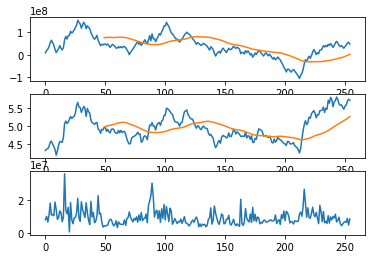

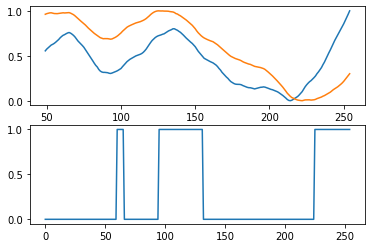

In [9]:
###Recommendation section 3: Recommendation based on volume
volume_recommendation("QAN.AX")